In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm
import missingno as msno
import seaborn as sns
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import warnings
warnings.simplefilter('ignore') # 
#from pandarallel import pandarallel
from scipy.interpolate import UnivariateSpline
  
# Initialization
#pandarallel.initialize()

In [2]:
multi_performance = pd.read_csv('FNMA_MF_Loan_Performance_Data_202406.csv')
mortgage_activity = pd.read_pickle('mortgage_activity.pickle')
#multi_performance = multi_performance[multi_performance['Loan Number'].isin(with_vol_list)]
# Convert 'Reporting Period Date' to datetime if not already
multi_performance['Reporting Period Date'] = pd.to_datetime(multi_performance['Reporting Period Date'])
# Convert 'Note Date' to datetime if not already
multi_performance['Note Date'] = pd.to_datetime(multi_performance['Note Date'])
multi_performance['Maturity Date at Acquisition'] = pd.to_datetime(multi_performance['Maturity Date at Acquisition'])
multi_performance['Maturity Date - Current'] = pd.to_datetime(multi_performance['Maturity Date - Current'])
# Extract the quarter for 'Note Date'
multi_performance['Note Quarter'] = multi_performance['Note Date'].dt.to_period('Q')

# Convert the difference from days to years (approximately)
#multi_performance['Maturity Year'] = ((multi_performance['Maturity Date at Acquisition'] - multi_performance['Note Date']).dt.days / 365.25).round(0)
multi_performance['Original Term Year'] = (multi_performance['Original Term']/ 12).round(0)
multi_performance['Amortization Year'] = (multi_performance['Amortization Term']/12).round(0)
# Sorting the DataFrame by 'Loan Number' and 'Reporting Period Dat  e'
multi_performance = multi_performance.sort_values(by=['Loan Number', 'Reporting Period Date'])

multi_performance['Original UPB'] = multi_performance['Original UPB'].replace('[\$,]', '', regex=True).astype(float)
multi_performance['UPB - Current'] = multi_performance['UPB - Current'].replace('[\$,]', '', regex=True).astype(float)
multi_performance['Acquisition Date'] = pd.to_datetime(multi_performance['Acquisition Date'])

multi_performance = multi_performance[multi_performance['Note Quarter'] > pd.Period('1999Q4', freq='Q-DEC')]

In [3]:
multi_performance['Loan Payment Status'].value_counts()

Loan Payment Status
Current                  4760065
90+ Days Delinquent        13880
30-59 Days Delinquent       5412
60-89 Days Delinquent       2796
Name: count, dtype: int64

In [4]:
multi_performance['30+ Days Delinquent'] = multi_performance['Loan Payment Status'].apply(lambda x: 1 if x in ['30-59 Days Delinquent', '60-89 Days Delinquent', '90+ Days Delinquent'] else 0)
multi_performance['60+ Days Delinquent'] = multi_performance['Loan Payment Status'].apply(lambda x: 1 if x in ['60-89 Days Delinquent', '90+ Days Delinquent'] else 0)
multi_performance['90+ Days Delinquent'] = multi_performance['Loan Payment Status'].apply(lambda x: 1 if x == '90+ Days Delinquent' else 0)

In [5]:
mortgage_activity = pd.read_pickle('mortgage_activity.pickle')

# Step 1: Create NOI_Bins using pd.qcut() for 1 to 10 bins based on 'Real Underwritten Annual NCF Per Unit'
mortgage_activity['NOI_Bins'] = pd.qcut(mortgage_activity['Real Underwritten Annual NCF Per Unit'], q=10, labels=range(1, 11))

# Step 2: Merge mortgage_activity with multi_performance based on 'Loan Number'
multi_performance = multi_performance.merge(mortgage_activity[['Loan Number', 'NOI_Bins','Real Underwritten Annual NCF Per Unit']], on='Loan Number',how='left')

In [6]:
def filter_and_generate_delinquency_data(multi_performance, years=5):
    # Convert years to months (assuming monthly data)
    months = years * 12
    
    # Group by 'Loan Number' and filter groups with more than the required number of months
    filtered_loans = multi_performance.groupby('Loan Number').filter(lambda x: len(x) > (months - 1))
    
    # Take the first 'months' rows for each 'Loan Number'
    filtered_loans = filtered_loans.groupby('Loan Number').head(months)
    
    # Generate 'ever 30+ Days Delinquent', 'ever 60+ Days Delinquent', and 'ever 90+ Days Delinquent'
    filtered_loans['ever 30+ Days Delinquent'] = filtered_loans.groupby('Loan Number')['30+ Days Delinquent'].transform(lambda x: 1 if (x == 1).any() else 0)
    filtered_loans['ever 60+ Days Delinquent'] = filtered_loans.groupby('Loan Number')['60+ Days Delinquent'].transform(lambda x: 1 if (x == 1).any() else 0)
    filtered_loans['ever 90+ Days Delinquent'] = filtered_loans.groupby('Loan Number')['90+ Days Delinquent'].transform(lambda x: 1 if (x == 1).any() else 0)
    
    # Keep only relevant columns and drop duplicates
    filtered_loans = filtered_loans[['Loan Number', 'NOI_Bins', 'Real Underwritten Annual NCF Per Unit', 
                                     'ever 30+ Days Delinquent', 'ever 60+ Days Delinquent', 'ever 90+ Days Delinquent']].drop_duplicates()
    
    return filtered_loans


In [7]:
# Initialize a dictionary to store filtered data for each year
filtered_loans_dict = {}

# Loop through years from 3 to 8 (since that's your range)
for year in range(3, 9):
    # Step 1: Use the custom function to get the filtered data based on years
    filtered_loans_temp = filter_and_generate_delinquency_data(multi_performance, years=year)
    
    # Step 2: Apply additional filtering to the temporary dataframe
    filtered_loans_temp = filtered_loans_temp[(filtered_loans_temp['Real Underwritten Annual NCF Per Unit'] > 1200) & 
                                              (filtered_loans_temp['Real Underwritten Annual NCF Per Unit'] < 42000)]
    
    # Store the filtered data for this year in the dictionary
    filtered_loans_dict[year] = filtered_loans_temp

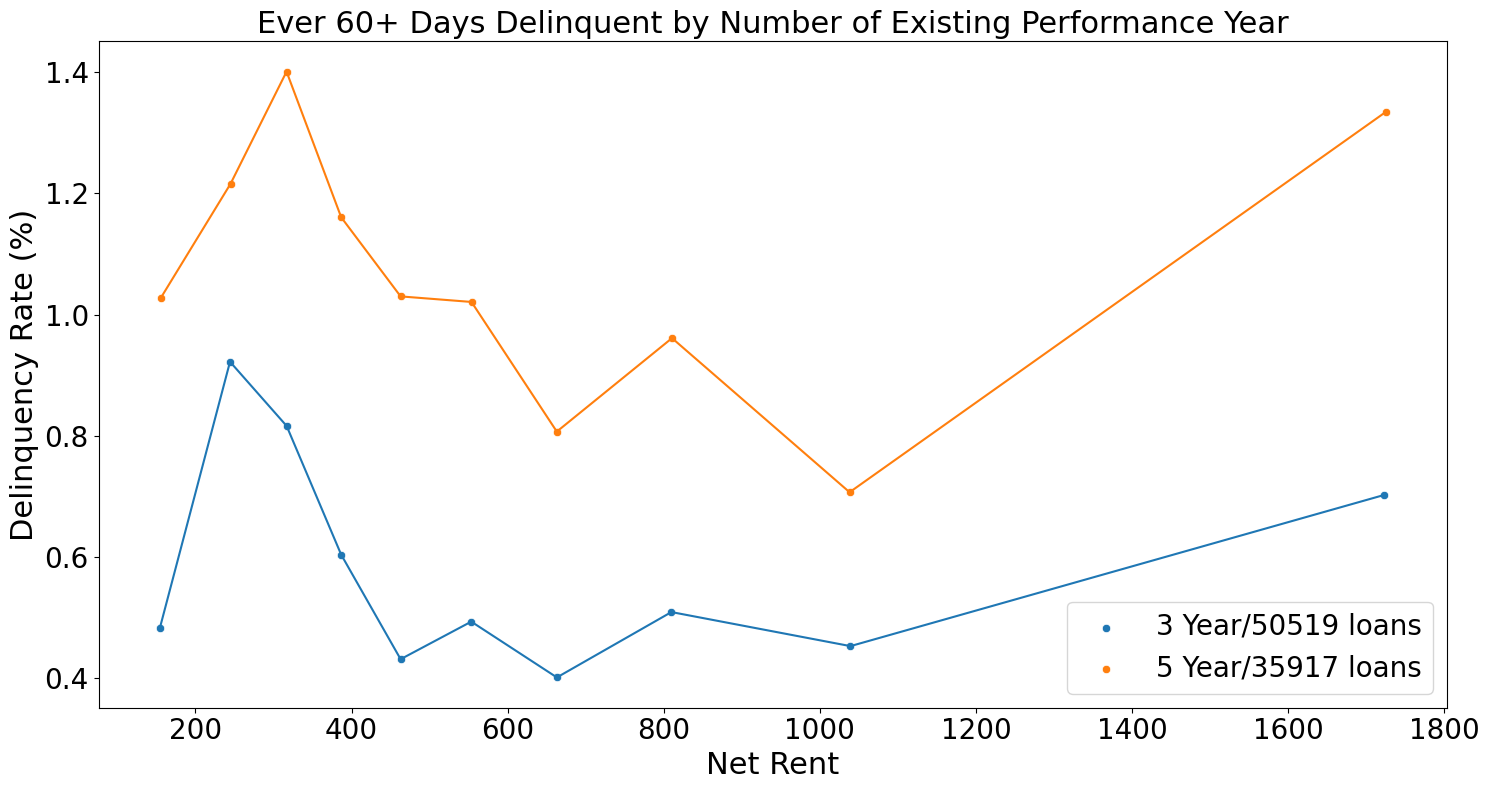

In [9]:
# Prepare for plotting
plt.figure(figsize=(15, 8))

# Loop through years 3 and 5 using the stored data in `filtered_loans_dict`
for year in [3, 5]:
    # Retrieve the filtered data for the current year from the stored dictionary
    filtered_loans_temp = filtered_loans_dict[year]
    
    # Get the number of loans for the current year
    num_loans = filtered_loans_temp['Loan Number'].nunique()

    # Step 3: Group by 'NOI_Bins' and calculate the percent delinquent for each category
    grouped = filtered_loans_temp.groupby('NOI_Bins').agg(
        total_loans=('Loan Number', 'size'),
        delinquent_60plus=('ever 60+ Days Delinquent', 'sum'),
        mean_ncf_per_unit=('Real Underwritten Annual NCF Per Unit', 'mean')
    ).reset_index()

    # Calculate the delinquency rates as percentages
    grouped['percent_60plus'] = (grouped['delinquent_60plus'] / grouped['total_loans']) * 100

    # New 250130
    grouped['mean_ncf_per_unit']/=12 # convert to monthly

    # Step 4: Plot the bin scatter plot for 60+ days delinquency
    sns.scatterplot(x='mean_ncf_per_unit', y='percent_60plus', data=grouped, marker='o', label=f'{year} Year/{num_loans} loans')
    sns.lineplot(x='mean_ncf_per_unit', y='percent_60plus', data=grouped, ci=None)


# New 250130
# Set labels and title
plt.title('Ever 60+ Days Delinquent by Number of Existing Performance Year', fontsize=22)
plt.xlabel('Net Rent', fontsize=22)
plt.ylabel('Delinquency Rate (%)', fontsize=22)

plt.legend(fontsize = 20, title_fontsize = 20)
plt.tick_params(axis='both', labelsize=20)  # Increase font size for both x and y ticks


# # Set labels and title
# plt.title('Ever 60+ Days Delinquent by Number of Existing Performance Year', fontsize=14)
# plt.xlabel('Real Underwritten Annual NCF Per Unit')
# plt.ylabel('Delinquency Rate (%)')

# # Add legend
# plt.legend()

# Adjust the layout to fit the plots and the final legend
plt.tight_layout()

plt.savefig('Figures/60day_Deli_noi_3_5.png')

plt.show()

# NOTE: Inforce Figure 14: Mortgage Delinquency Rate by NOI Level   60day_Deli_noi_3_5.png

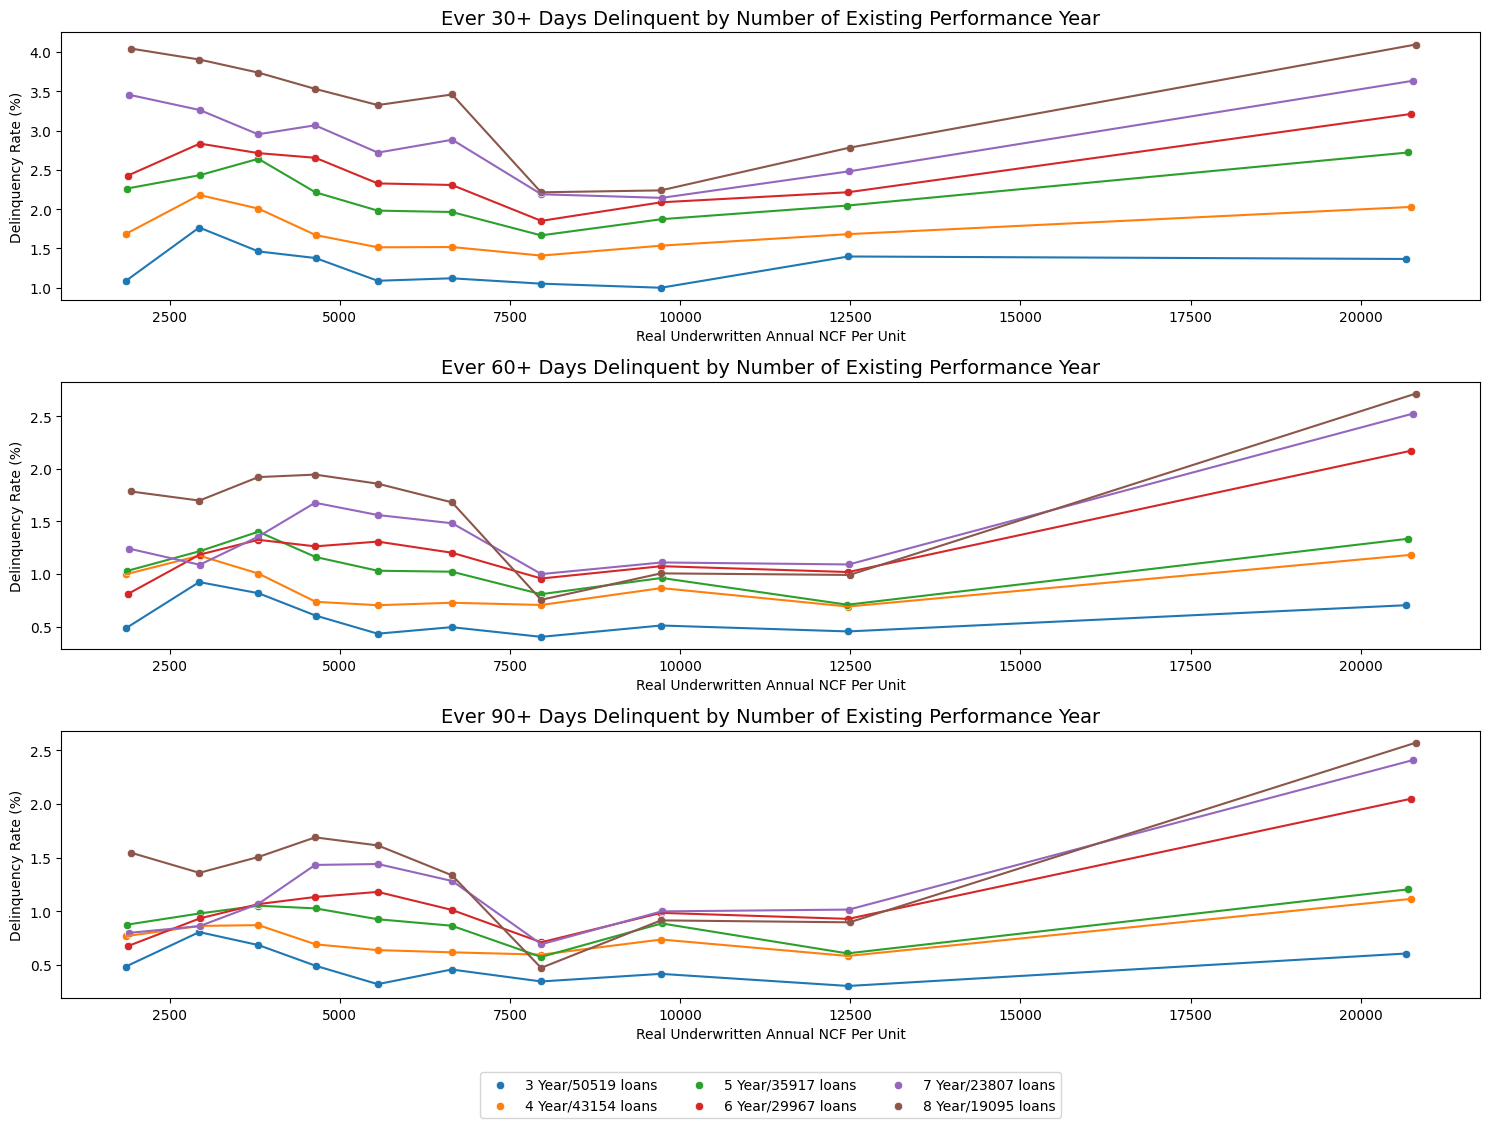

In [9]:
# Prepare for plotting
plt.figure(figsize=(15, 12))

# Loop through years from 3 to 8 (since that's your range) using the stored data in `filtered_loans_dict`
for year in range(3, 9):
    # Retrieve the filtered data for the current year from the stored dictionary
    filtered_loans_temp = filtered_loans_dict[year]
    
    # Get the number of loans for the current year
    num_loans = filtered_loans_temp['Loan Number'].nunique()

    # Step 3: Group by 'NOI_Bins' and calculate the percent delinquent for each category
    grouped = filtered_loans_temp.groupby('NOI_Bins').agg(
        total_loans=('Loan Number', 'size'),
        delinquent_30plus=('ever 30+ Days Delinquent', 'sum'),
        delinquent_60plus=('ever 60+ Days Delinquent', 'sum'),
        delinquent_90plus=('ever 90+ Days Delinquent', 'sum'),
        mean_ncf_per_unit=('Real Underwritten Annual NCF Per Unit', 'mean')
    ).reset_index()

    # Calculate the delinquency rates as percentages
    grouped['percent_30plus'] = (grouped['delinquent_30plus'] / grouped['total_loans']) * 100
    grouped['percent_60plus'] = (grouped['delinquent_60plus'] / grouped['total_loans']) * 100
    grouped['percent_90plus'] = (grouped['delinquent_90plus'] / grouped['total_loans']) * 100

    # Step 4: Plot the bin scatter plot for each delinquency category (30+, 60+, 90+ days)

    # Plot for ever 30+ delinquent
    plt.subplot(3, 1, 1)  # First plot (1st row)
    sns.scatterplot(x='mean_ncf_per_unit', y='percent_30plus', data=grouped, marker='o')
    sns.lineplot(x='mean_ncf_per_unit', y='percent_30plus', data=grouped, ci=None)
    plt.title('Ever 30+ Days Delinquent by Number of Existing Performance Year', fontsize=14)
    plt.xlabel('Real Underwritten Annual NCF Per Unit')
    plt.ylabel('Delinquency Rate (%)')

    # Plot for ever 60+ delinquent
    plt.subplot(3, 1, 2)  # Second plot (2nd row)
    sns.scatterplot(x='mean_ncf_per_unit', y='percent_60plus', data=grouped, marker='o')
    sns.lineplot(x='mean_ncf_per_unit', y='percent_60plus', data=grouped, ci=None)
    plt.title('Ever 60+ Days Delinquent by Number of Existing Performance Year', fontsize=14)
    plt.xlabel('Real Underwritten Annual NCF Per Unit')
    plt.ylabel('Delinquency Rate (%)')

    # Plot for ever 90+ delinquent
    plt.subplot(3, 1, 3)  # Third plot (3rd row)
    sns.scatterplot(x='mean_ncf_per_unit', y='percent_90plus', data=grouped, marker='o', label=f'{year} Year/{num_loans} loans')
    sns.lineplot(x='mean_ncf_per_unit', y='percent_90plus', data=grouped, ci=None)
    plt.title('Ever 90+ Days Delinquent by Number of Existing Performance Year', fontsize=14)
    plt.xlabel('Real Underwritten Annual NCF Per Unit')
    plt.ylabel('Delinquency Rate (%)')

# Add the legend only to the third subplot
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3, fontsize=10)

# Adjust the layout to fit the plots and the final legend
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# NOTE: Inforce Figure 20: Mortgage Delinquency Rates  Deli_noi.png

In [10]:
filtered_loans_5yr = filtered_loans_dict[5]

In [11]:
multi_performance['Note Year'] = multi_performance['Note Date'].dt.year

In [12]:
filtered_loans_5yr = filtered_loans_5yr.merge(multi_performance[['Loan Number','Note Year','Property State']].drop_duplicates(), on='Loan Number', how='left')

In [13]:
# Group by 'Property State' and 'Note Year' and calculate the total loans and delinquent loans
state_grouped = filtered_loans_5yr.groupby(['Property State']).agg(
    total_loans=('Loan Number', 'size'),
    delinquent_60plus=('ever 60+ Days Delinquent', 'sum')
).reset_index()

# Calculate the delinquency rate as a percentage
state_grouped['delinquency_rate_60+'] = (state_grouped['delinquent_60plus'] / state_grouped['total_loans'])

In [14]:
all_rps = pd.read_csv('all_rps.csv')
# Create a mapping dictionary for state names to their two-letter abbreviations
state_abbreviation_mapping = {
    'california': 'CA', 'oregon': 'OR', 'new-york': 'NY', 'vermont': 'VT', 'washington-dc': 'DC',
    'maryland': 'MD', 'maine': 'ME', 'delaware': 'DE', 'colorado': 'CO', 'connecticut': 'CT',
    'new-jersey': 'NJ', 'massachusetts': 'MA', 'hawaii': 'HI', 'washington': 'WA', 'rhode-island': 'RI',
    'pennsylvania': 'PA', 'michigan': 'MI', 'iowa': 'IA', 'nebraska': 'NE', 'nevada': 'NV',
    'new-hampshire': 'NH', 'alaska': 'AK', 'montana': 'MT', 'north-carolina': 'NC', 'virginia': 'VA',
    'new-mexico': 'NM', 'florida': 'FL', 'illinois': 'IL', 'north-dakota': 'ND', 'arizona': 'AZ',
    'utah': 'UT', 'wisconsin': 'WI', 'georgia': 'GA', 'kansas': 'KS', 'texas': 'TX',
    'idaho': 'ID', 'indiana': 'IN', 'ohio': 'OH', 'south-carolina': 'SC', 'missouri': 'MO',
    'kentucky': 'KY', 'south-dakota': 'SD', 'louisiana': 'LA', 'tennessee': 'TN', 'west-virginia': 'WV',
    'arkansas': 'AR', 'wyoming': 'WY', 'mississippi': 'MS', 'alabama': 'AL', 'oklahoma': 'OK'
}

# Apply the mapping to the State column
all_rps['State'] = all_rps['State'].map(state_abbreviation_mapping)

In [15]:
all_rps

,State,4o-mini RPS Score,o1-mini RPS Score,Claude RPS Score,Gemeni RPS Score,Milcheva RPS,4o-mini RPS Rank,o1-mini RPS Rank,Claude RPS Rank,Gemeni RPS Rank,Milcheva RPS Rank
0,CA,30,28,26,23,17,1,1,4,4,12
1,OR,30,28,24,22,18,1,1,7,5,7
2,NaN,21,26,26,17,15,11,3,4,32,20
3,NY,30,26,30,24,11,1,3,1,2,33
4,VT,22,26,24,17,22,7,3,7,32,1
5,DC,29,26,26,28,17,4,3,4,1,12
6,MD,19,24,28,24,12,19,7,3,2,30
7,ME,21,23,18,19,17,11,8,21,13,12
8,DE,20,23,16,20,21,16,8,32,8,2
9,CO,20,23,17,19,7,16,8,28,13,43


In [16]:
all_rps = all_rps.merge(state_grouped.sort_values(by='delinquency_rate_60+', ascending=False), left_on='State', right_on='Property State', how='left')

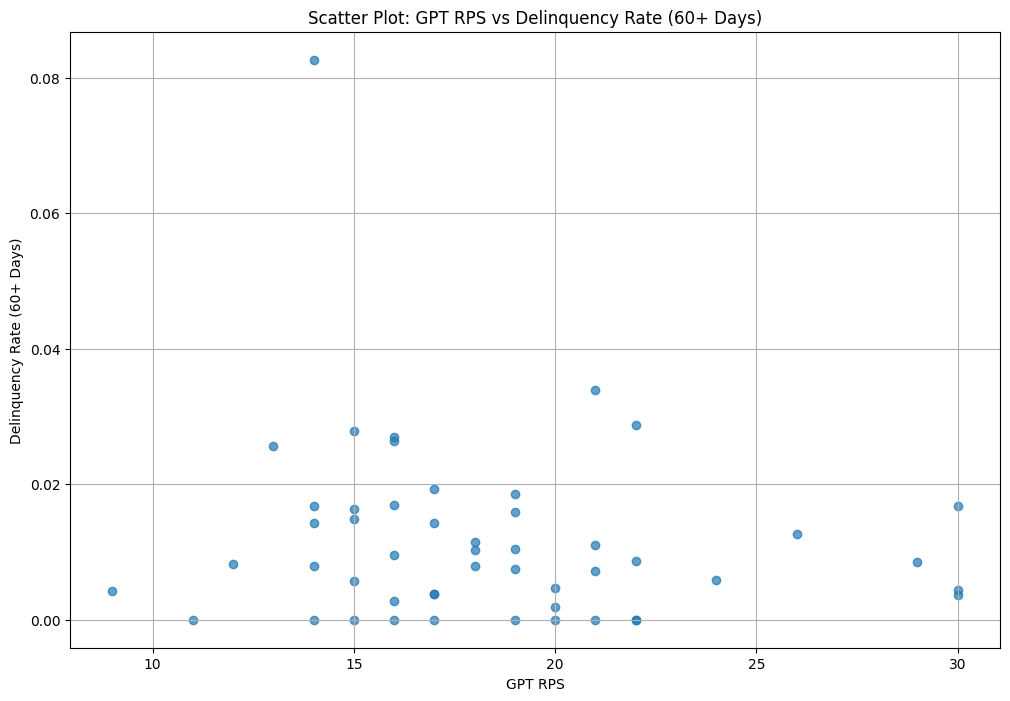

In [17]:
# Scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(all_rps['4o-mini RPS Score'], all_rps['delinquency_rate_60+'], alpha=0.7)
plt.title('Scatter Plot: GPT RPS vs Delinquency Rate (60+ Days)')
plt.xlabel('GPT RPS')
plt.ylabel('Delinquency Rate (60+ Days)')
plt.grid(True)
plt.show()

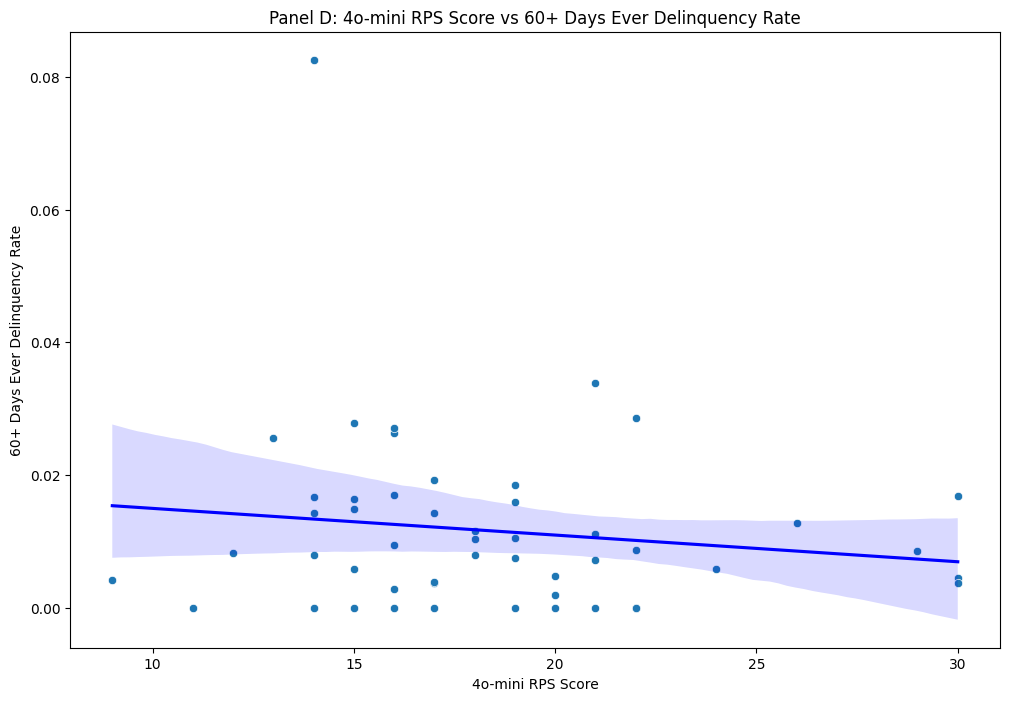

In [18]:
# Panel D: 4o-mini RPS Score score (x-axis) against McCollum & Milcheva RPS score (y-axis)
plt.figure(figsize=(12, 8))

sns.scatterplot(data=all_rps, x='4o-mini RPS Score', y='delinquency_rate_60+')
sns.regplot(data=all_rps, x='4o-mini RPS Score', y='delinquency_rate_60+', scatter=False, color='blue')
plt.title('Panel D: 4o-mini RPS Score vs 60+ Days Ever Delinquency Rate')
plt.xlabel('4o-mini RPS Score')
plt.ylabel('60+ Days Ever Delinquency Rate')
plt.show()

# NOTE: Inforce Figure 24: Comparing Our RPS to Other Tenant Risk Metrics scatter_llm_rps.png